In [22]:
import time
import warnings
import numpy as np
import pywt
import os
import scipy.io as sio
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from operator import truediv
import spectral
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, classification_report,
                             cohen_kappa_score, confusion_matrix)
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from tensorflow.keras.layers import (Dense, Dropout, Activation,
                                     Concatenate, Input, Flatten,
                                     Reshape, Lambda)
from tensorflow.keras.models import Sequential, Model
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical
from keras.optimizers import legacy
from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam

In [23]:
## Important Parameters
num_epochs = 50
batch_size = 256
k = 15
WS = 4
teRatio = 0.50
vrRatio = 0.50
trRatio = 0.50
adam = tf.keras.optimizers.legacy.Adam(lr = 0.001, decay = 1e-06)

/home/ahmad/miniconda3/envs/hsi/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [24]:
## Reading HSI
def LoadHSIData(method):
    data_path = os.path.join(os.getcwd(),'../HSI/')
    if method == 'HC':
        HSI = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan.mat'))['WHU_Hi_HanChuan']
        GT = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan_gt'))['WHU_Hi_HanChuan_gt']
        Num_Classes = 16
    elif method == 'UH':
        HSI = sio.loadmat(os.path.join(data_path, 'HU.mat'))['HSI']
        GT = sio.loadmat(os.path.join(data_path, 'HU_gt.mat'))['gt']
        Num_Classes = 15
    return HSI, GT, Num_Classes

In [25]:
## Different Dimensional Reduction Methods
def DLMethod(method, HSI, NC = 75):
    RHSI = np.reshape(HSI, (-1, HSI.shape[2]))
    if method == 'PCA': ## PCA
        pca = PCA(n_components = NC, whiten = True)
        RHSI = pca.fit_transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    return RHSI

## 3-D HSI slices
def ImageCubes(HSI, GT, WS = WS, removeZeroLabels = True):
    margin = int((WS) / 2)
    zeroPaddedX = ZeroPad(HSI, margin = margin)
    ## split patches
    patchesData = np.zeros((HSI.shape[0] * HSI.shape[1], WS, WS, HSI.shape[2]))
    patchesLabels = np.zeros((HSI.shape[0] * HSI.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin, c - margin:c + margin]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = GT[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

## Padding around HSI
def ZeroPad(HSI, margin = 2):
    NHSI = np.zeros((HSI.shape[0] + 2 * margin, HSI.shape[1] + 2* margin, HSI.shape[2]))
    x_offset = margin
    y_offset = margin
    NHSI[x_offset:HSI.shape[0] + x_offset, y_offset:HSI.shape[1] + y_offset, :] = HSI
    return NHSI

## Compute the Patch to Prepare for Ground Truths
def Patch(HSI,height_index,width_index):
    height_slice = slice(height_index, height_index+WS)
    width_slice = slice(width_index, width_index+WS)
    patch = HSI[height_slice, width_slice, :]
    return patch

In [26]:
## Assigning Class Labels for Final Classification and Confusion Matrices
def ClassificationReports(TeC, HSID, Te_Pred):
    Te_Pred = np.argmax(Te_Pred, axis=1)
    if HSID == 'HC':
        target_names = ['Strawberry', 'Cowpea', 'Soybean', 'Sorghum',
                        'Water spinach', 'Watermelon', 'Greens', 'Trees', 'Grass',
                        'Red roof', 'Gray roof', 'Plastic', 'Bare soil', 'Road',
                        'Bright object', 'Water']
    elif HSID == 'UH':
        target_names = ['Healthy grass', 'Stressed grass', 'Synthetic grass', 'Trees',
                    'Soil', 'Water', 'Residential', 'Commercial', 'Road',
                    'Highway', 'Railway', 'Parking Lot 1', 'Parking Lot 2',
                    'Tennis Court', 'Running Track']
    classification = classification_report(np.argmax(TeC, axis=1), Te_Pred, target_names = target_names)
    oa = accuracy_score(np.argmax(TeC, axis=1), Te_Pred)
    confusion = confusion_matrix(np.argmax(TeC, axis=1), Te_Pred)
    list_diag = np.diag(confusion)
    list_raw_sum = np.sum(confusion, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    aa = np.mean(each_acc)
    kappa = cohen_kappa_score(np.argmax(TeC, axis=1), Te_Pred)
    return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100, target_names

## Writing Results in CSV files
def CSVResults(file_name, classification, confusion, Tr_Time, Te_Time, DL_Time, kappa, oa, aa, each_acc):
    classification = str(classification)
    confusion = str(confusion)
    with open(file_name, 'w') as CSV_file:
      CSV_file.write('{} Tr_Time'.format(Tr_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Te_Time'.format(Te_Time))
      CSV_file.write('\n')
      CSV_file.write('{} DL_Time'.format(DL_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Kappa accuracy (%)'.format(kappa))
      CSV_file.write('\n')
      CSV_file.write('{} Overall accuracy (%)'.format(oa))
      CSV_file.write('\n')
      CSV_file.write('{} Average accuracy (%)'.format(aa))
      CSV_file.write('\n')
      CSV_file.write('{}'.format(classification))
      CSV_file.write('\n')
      CSV_file.write('{}'.format(each_acc))
      CSV_file.write('\n')
      CSV_file.write('{}'.format(confusion))
    return CSV_file

## Plot Ground Truths
def GT_Plot(CRDHSI, GT, model, WS, k):
  Predicted = model.predict(CRDHSI)
  Predicted = np.argmax(Predicted, axis=1)
  height, width = np.shape(GT)
  ## Calculate the predicted Ground Truths
  outputs = np.zeros((height, width))
  count = 0
  for AA in range(height):
    for BB in range(width):
      target = int(GT[AA,BB])
      if target == 0:
        continue
      else:
        outputs[AA][BB] = Predicted[count]
        count = count+1
  return outputs

In [27]:
def TrTeSplit(HSI, GT, trRatio, vrRatio, teRatio, randomState=345):
    # Split into train and test sets
    Tr, Te, TrC, TeC = train_test_split(HSI, GT, test_size=teRatio,
                                        random_state=randomState, stratify=GT)
    # Calculate the validation ratio based on the updated test and train ratios
    totalTrRatio = trRatio + vrRatio
    new_vrRatio = vrRatio / totalTrRatio
    # Split train set into train and validation sets
    Tr, Va, TrC, VaC = train_test_split(Tr, TrC, test_size=new_vrRatio,
                                        random_state=randomState, stratify=TrC)

    return Tr, Va, Te, TrC, VaC, TeC

In [28]:
## Global Parameters
HSID = "UH" ## ""HC"
DLM = "PCA"
## Main Function to load Datasets, Dimensional Reduction and Creating Patchs for CNN
HSI, GT, Num_Classes = LoadHSIData(HSID)
## Reduce the Dimensionality
start = time.time()
RDHSI = DLMethod(DLM, HSI, NC = k)
end = time.time()
DL_Time = end - start
## Create Image Cubes for Model Building
CRDHSI, CGT = ImageCubes(RDHSI, GT, WS = WS)
## Split Train/validation and Test sets
Tr, Va, Te, TrC, VaC, TeC = TrTeSplit(CRDHSI, CGT, trRatio, vrRatio, teRatio)
# Reshape train, validation, and test sets
Tr = Tr.reshape(-1, WS, WS, k, 1)
TrC = to_categorical(TrC)
Va = Va.reshape(-1, WS, WS, k, 1)
VaC = to_categorical(VaC)
Te = Te.reshape(-1, WS, WS, k, 1)
TeC = to_categorical(TeC)

**Spatial-Spectral Wavelet Mamba**


In [29]:
class SpectralSpatialTokenGeneration(tf.keras.layers.Layer):
    def __init__(self, out_channels, **kwargs):
        super(SpectralSpatialTokenGeneration, self).__init__(**kwargs)
        self.spatial_tokens = Dense(out_channels)
        self.spectral_tokens = Dense(out_channels)
    def call(self, x):
        B, H, W, C = x.shape
        # Use tf.shape to handle dynamic batch dimension
        spatial_tokens = self.spatial_tokens(tf.reshape(tf.transpose(x, [0, 2, 3, 1]), [tf.shape(x)[0], H * W, C]))
        spectral_tokens = self.spectral_tokens(tf.reshape(tf.transpose(x, [0, 1, 2, 3]), [tf.shape(x)[0], H * W, C]))
        return spatial_tokens,spectral_tokens

class SpectralSpatialFeatureEnhancement(tf.keras.layers.Layer):
    def __init__(self, out_channels, **kwargs):  # Add 'self'
        super(SpectralSpatialFeatureEnhancement, self).__init__(**kwargs)
        self.spatial_gate = Sequential([
            Dense(out_channels),
            Activation('sigmoid'),
            # Reshape the output to match spatial_tokens
            Reshape((1, out_channels))
        ])
        self.spectral_gate = Sequential([
            Dense(out_channels),
            Activation('sigmoid'),
            # Reshape the output to match spectral_tokens
            Reshape((1, out_channels))
        ])
    def call(self, spatial_tokens, spectral_tokens, center_tokens):
        spatial_enhanced = spatial_tokens * self.spatial_gate(center_tokens)
        spectral_enhanced = spectral_tokens * self.spectral_gate(center_tokens)
        return spatial_enhanced, spectral_enhanced

class StateSpaceModel(tf.keras.layers.Layer):
    def __init__(self, state_dim, **kwargs):
        super(StateSpaceModel, self).__init__(**kwargs)
        self.state_dim = state_dim
        self.state_transition = Dense(units=state_dim, activation="relu")
        self.state_update = Dense(units=state_dim, activation="relu")
    def call(self, x):
        state = tf.zeros([tf.shape(x)[0], self.state_dim])
        for t in range(tf.shape(x)[1]):
            # Flatten the input if it has more than 2 dimensions
            input_t = tf.reshape(x[:, t, :], [tf.shape(x)[0], -1])
            state = self.state_transition(state) + self.state_update(input_t)
        return state

class SSMambaModel(tf.keras.Model):
    def __init__(self, out_channels, num_heads, state_dim, Num_Classes, dropout=0.1, **kwargs):
        super(SSMambaModel, self).__init__(**kwargs)
        self.token_generation = SpectralSpatialTokenGeneration(out_channels)
        self.feature_enhancement = SpectralSpatialFeatureEnhancement(out_channels)
        self.state_space_model = StateSpaceModel(state_dim)
        self.dense = Dense(units=128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.dropout = Dropout(0.4)
        self.classifier = Dense(Num_Classes, activation='softmax')
    def apply_wavelet_transform(self, image, wavelet_name='haar'):
        """'haar', 'db1', 'db2', 'coif1', 'bior1.3'"""
        image_np = tf.make_ndarray(tf.make_tensor_proto(image))
        if wavelet_name not in pywt.wavelist(kind='discrete'):
            raise ValueError(f"The wavelet {wavelet_name} is not supported for discrete wavelet transform.")
        coeffs = pywt.dwt2(image_np, wavelet_name)
        cA, (cH, cV, cD) = coeffs
        transformed = np.stack([cA, cH, cV, cD], axis=-1)
        return tf.convert_to_tensor(transformed, dtype=tf.float32)
    def call(self, x):
        spatial_tokens, spectral_tokens = self.token_generation(x)
        center_tokens = spatial_tokens[:, x.shape[1] // 2, :]
        spatial_tokens, spectral_tokens = self.feature_enhancement(spatial_tokens, spectral_tokens, center_tokens)
        spatial_tokens = tf.map_fn(lambda t: tf.numpy_function(self.apply_wavelet_transform, [t], tf.float32), spatial_tokens, dtype=tf.float32)
        spectral_tokens = tf.map_fn(lambda t: tf.numpy_function(self.apply_wavelet_transform, [t], tf.float32), spectral_tokens, dtype=tf.float32)
        Combined_Tokens = tf.concat([spatial_tokens, spectral_tokens], axis=-1)
        state_output = self.state_space_model(Combined_Tokens)
        output = self.classifier(state_output)
        return output

def WaveMamba(Tr, batch_size, Num_Classes):
    model = SSMambaModel(out_channels=64, num_heads=4, state_dim=128, Num_Classes=Num_Classes, dropout=0.1)
    sample_input = Tr[:batch_size]
    _ = model(sample_input)
    return model

In [30]:
def train_and_evaluate_model(model_name, Tr, TrC, Va, VaC, Te, TeC, adam, CRDHSI, HSID, teRatio, k, WS, DLM, RDHSI, GT,Num_Classes,batch_size,epochs):
    print(f"Model name: {model_name}")    
    if model_name == WaveMamba:
      ## Transform Training/Validation/Test samples
      Tr = Tr.reshape(-1, WS, WS, k)
      Va = Va.reshape(-1, WS, WS, k)
      Te = Te.reshape(-1, WS, WS, k)
      model = WaveMamba(Tr, batch_size, Num_Classes)
    # else:
    #   model = model_name(WS, k, Num_Classes)
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    start = time.time()
    history = model.fit(x=Tr, y=TrC, batch_size=batch_size, epochs=epochs, validation_data=(Va, VaC))
    end = time.time()
    Tr_Time = end - start
    start = time.time()
    Te_Pred = model.predict(Te)
    end = time.time()
    Te_Time = end - start
    classification,confusion,oa,each_acc,aa,kappa,target_names = ClassificationReports(TeC, HSID, Te_Pred)
    print(classification)
    file_name = f"{HSID}_{teRatio}_{k}_{WS}_{DLM}_Report_{model_name.__name__}.csv"
    CSV_file = CSVResults(file_name, classification, confusion, Tr_Time, Te_Time, DL_Time, kappa, oa, aa, each_acc)
    outputs = GT_Plot(CRDHSI, GT, model, WS, k)
    plt.figure(figsize=(10, 10))
    plt.imshow(outputs, cmap='nipy_spectral')
    plt.axis('off')
    file_name = f"{HSID}_{teRatio}_{k}_{WS}_{DLM}_Ground_Truths_{model_name.__name__}.png"
    plt.savefig(file_name, dpi=500, format='png', bbox_inches='tight', pad_inches=0)
    return history

Model name: <function WaveMamba at 0x7f39ed365c60>
Model: "ss_mamba_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spectral_spatial_token_gen  multiple                  2048      
 eration_2 (SpectralSpatial                                      
 TokenGeneration)                                                
                                                                 
 spectral_spatial_feature_e  multiple                  8320      
 nhancement_2 (SpectralSpat                                      
 ialFeatureEnhancement)                                          
                                                                 
 state_space_model_2 (State  multiple                  49408     
 SpaceModel)                                                     
                                                                 
 dense_22 (Dense)            multiple                  0 (unused)

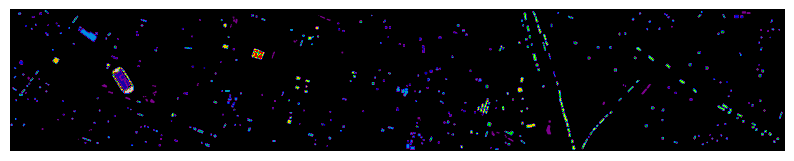

In [31]:
# Define a list of model names
model_names = [WaveMamba]
history_list = []
features_list = []
Labels_list = []
for model_name in model_names:
  history = train_and_evaluate_model(model_name, Tr, TrC, Va, VaC, Te, TeC,
                                       adam, CRDHSI, HSID, teRatio, k, WS,
                                       DLM, RDHSI, GT, Num_Classes, batch_size, num_epochs)
  history_list.append(history)

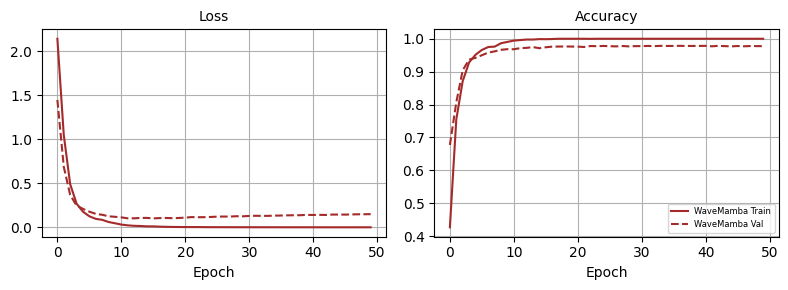

In [32]:
# Plot training and validation loss and accuracy for each model
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
colors = ['brown', 'gray', 'blue', 'green', 'purple', 'orange', 'red']

for i, history in enumerate(history_list):
    # Plot loss
    axs[0].plot(history.history['loss'], label=f'{model_names[i].__name__} Train', color=colors[i])
    axs[0].plot(history.history['val_loss'], label=f'{model_names[i].__name__} Val', color=colors[i], linestyle='--')
    # Plot accuracy
    axs[1].plot(history.history['accuracy'], label=f'{model_names[i].__name__} Train', color=colors[i])
    axs[1].plot(history.history['val_accuracy'], label=f'{model_names[i].__name__} Val', color=colors[i], linestyle='--')
axs[0].set_title('Loss', fontsize=10)
axs[0].set_xlabel('Epoch', fontsize=10)
axs[1].set_title('Accuracy', fontsize=10)
axs[1].set_xlabel('Epoch', fontsize=10)
axs[1].legend(fontsize=6)
axs[0].grid(True)
axs[1].grid(True)
plt.tight_layout()
file_name = f"{HSID}_{teRatio}_{k}_{WS}_{DLM}_acc_loss_curve_all_models.png"
plt.savefig(file_name, dpi=500, format='png', bbox_inches='tight', pad_inches=0)